In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/data.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.drop(['PassengerId', 'Name'], axis=1, inplace=True)
df.shape

(891, 10)

# Target

Survived
0    549
1    342
Name: count, dtype: int64 Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


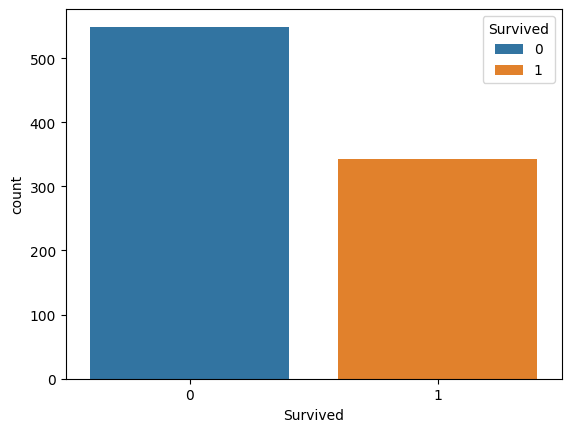

In [4]:
target = 'Survived'

sns.countplot(df, x=target, hue=target)
print(df[target].value_counts(), df[target].value_counts(normalize=True))

# Var type

In [5]:
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
print(len(cat_vars), cat_vars)

4 ['Sex', 'Ticket', 'Cabin', 'Embarked']


In [6]:
num_vars = [var for var in df.columns if var not in cat_vars and var != target]
print(len(num_vars), num_vars)

5 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


# Missing data

In [7]:
var_with_na = [var for var in df.columns if df[var].isna().sum() > 0]
df[var_with_na].isna().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

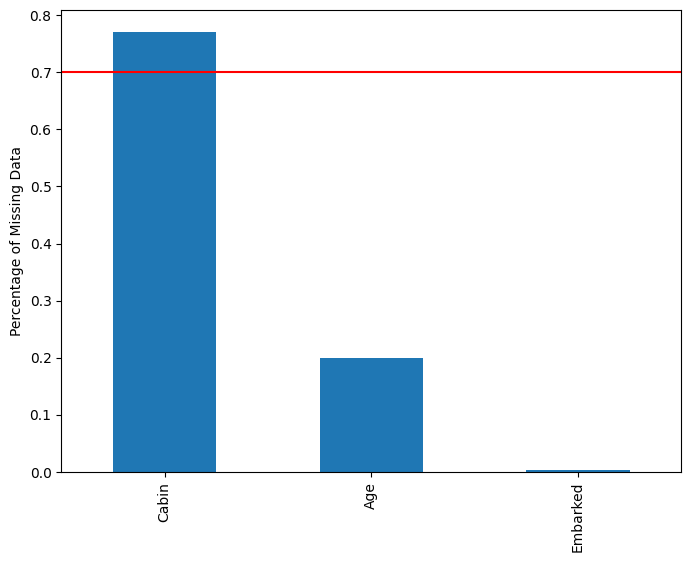

In [8]:
df[var_with_na].isna().mean().sort_values(ascending=False).plot(kind='bar', figsize=(8, 6))
plt.ylabel('Percentage of Missing Data')
plt.axhline(y=0.7, color='r');

In [9]:
cat_na = [var for var in cat_vars if var in var_with_na]
num_na = [var for var in num_vars if var in var_with_na]

print('Number of categorical features with na: ', len(cat_na), cat_na)
print('Number of numerical features with na: ', len(num_na), num_na)

Number of categorical features with na:  2 ['Cabin', 'Embarked']
Number of numerical features with na:  1 ['Age']


# Relationship between na and Target feature

In [10]:
def analyse_na_value(df, var):
    df = df.copy()
    df[var] = np.where(df[var].isna(), 1, 0)

    tmp = df.groupby(var)[target].agg(['mean', 'std'])
    tmp.plot(kind='barh', y='mean', legend=False,
             xerr='std', title=target, color='green')
    plt.show()

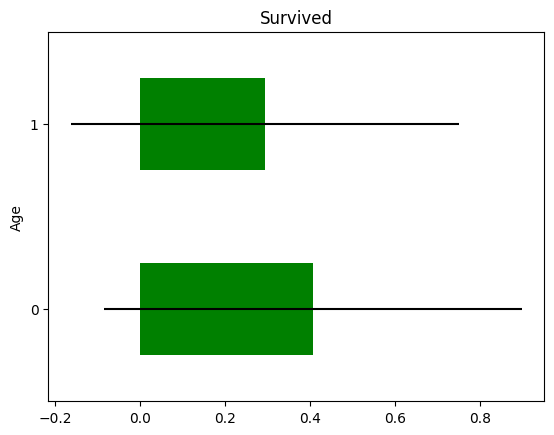

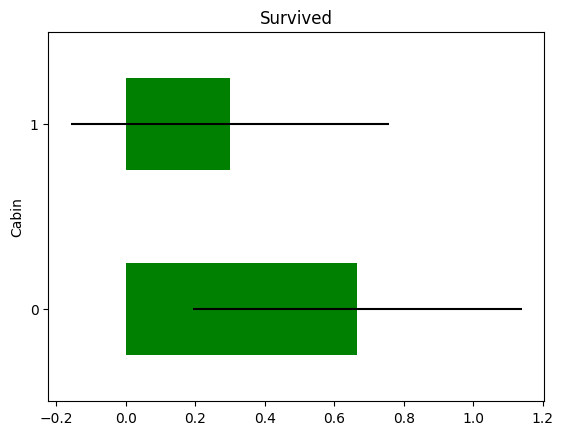

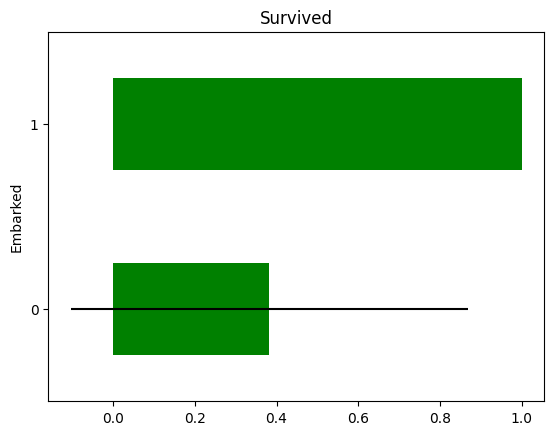

In [11]:
for var in var_with_na:
    analyse_na_value(df, var)

# Numerical Features

In [12]:
print(len(num_vars))
df[num_vars].head()

5


,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


### Discrete Features

In [13]:
discrete_var = [var for var in num_vars if df[var].nunique() < 20]
print(len(discrete_var))
df[discrete_var].head()

3


,Pclass,SibSp,Parch
0,3,1,0
1,1,1,0
2,3,0,0
3,1,1,0
4,3,0,0


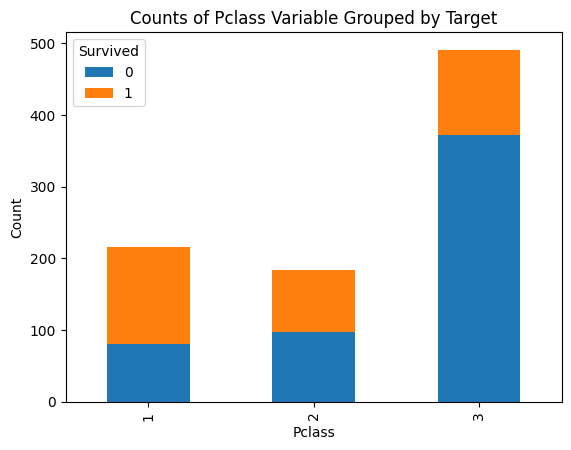

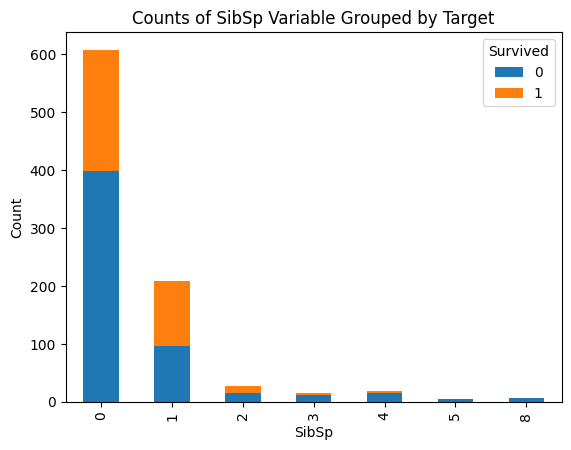

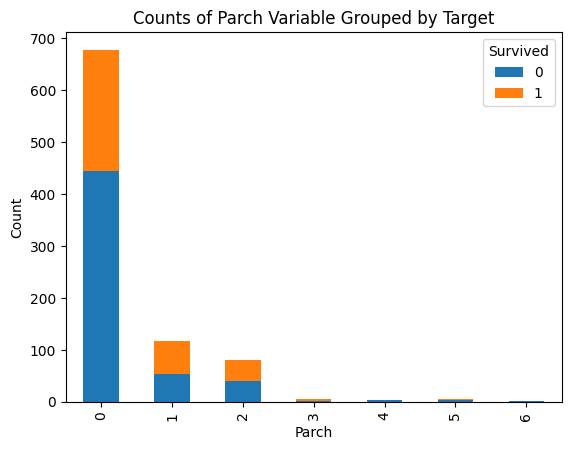

In [14]:
for var in discrete_var:
    ct = pd.crosstab(df[var], df[target])

    ct.plot(kind='bar', stacked=True)
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.title(f'Counts of {var} Variable Grouped by Target')
    plt.show()

### Continuous Feature

In [15]:
continuouse_var = [var for var in num_vars if var not in discrete_var]
print(len(continuouse_var))
df[continuouse_var].head()

2


,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


/Users/yaheaal/Desktop/deploying-machine-learning-models/env/lib/python3.10/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


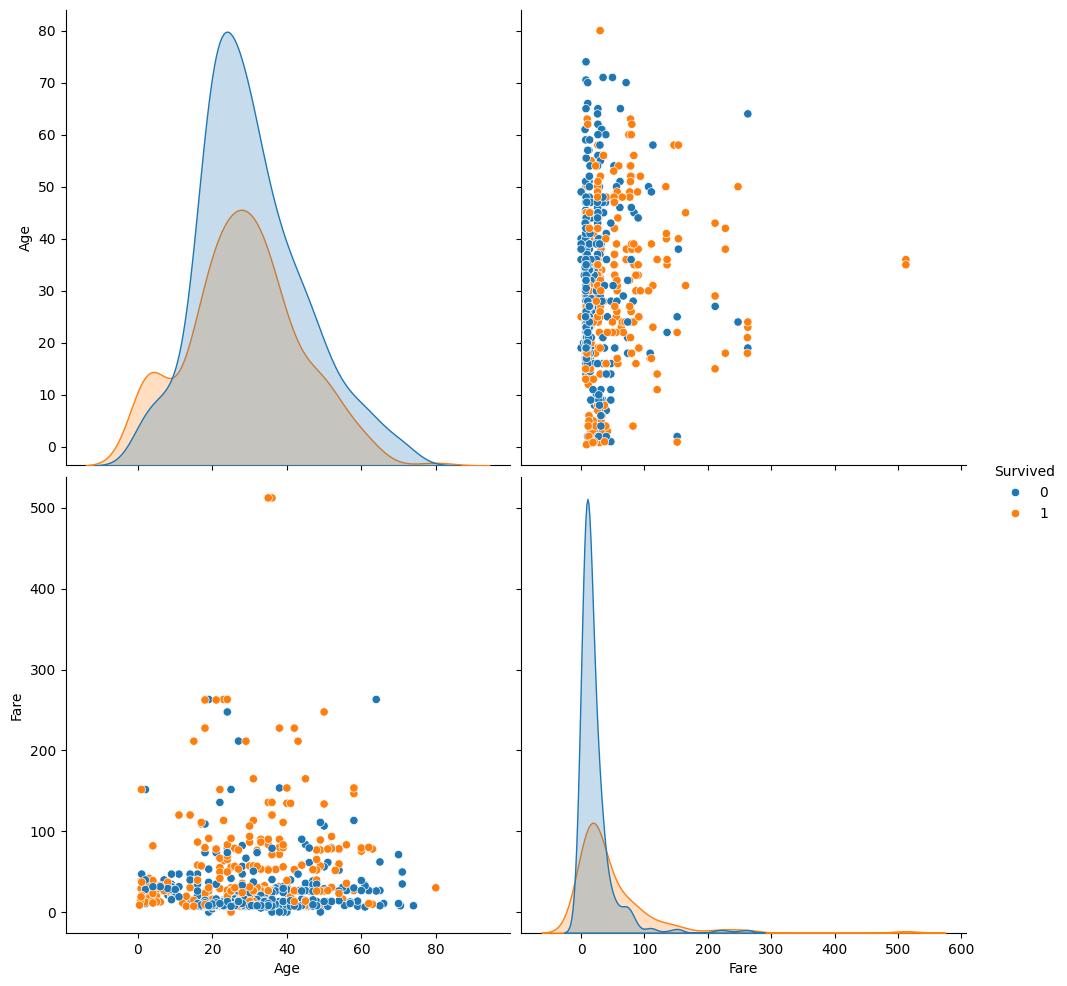

In [16]:
sns.pairplot(df[continuouse_var+[target]], hue=target, size=5);

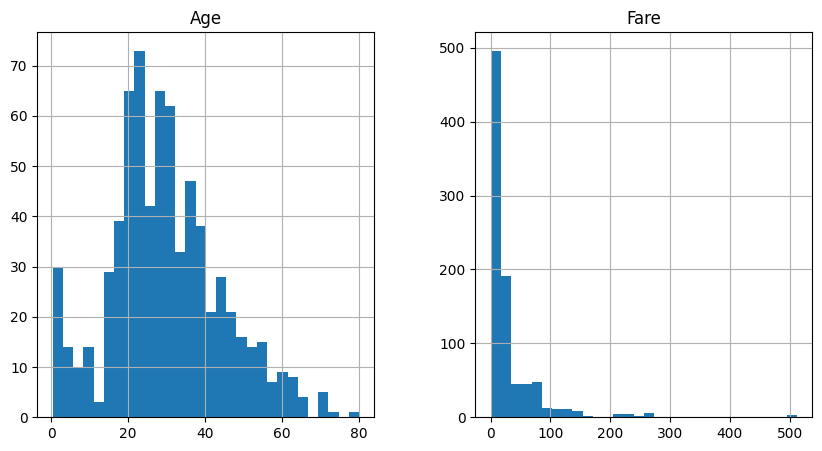

In [17]:
df[continuouse_var].hist(bins=30, figsize=(10, 5));

/var/folders/v9/c6z_1xyn2rn5f9j2x3jxhgcm0000gn/T/ipykernel_15069/1929620157.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tmp[var], param = stats.yeojohnson(df[var].fillna(method='bfill'))


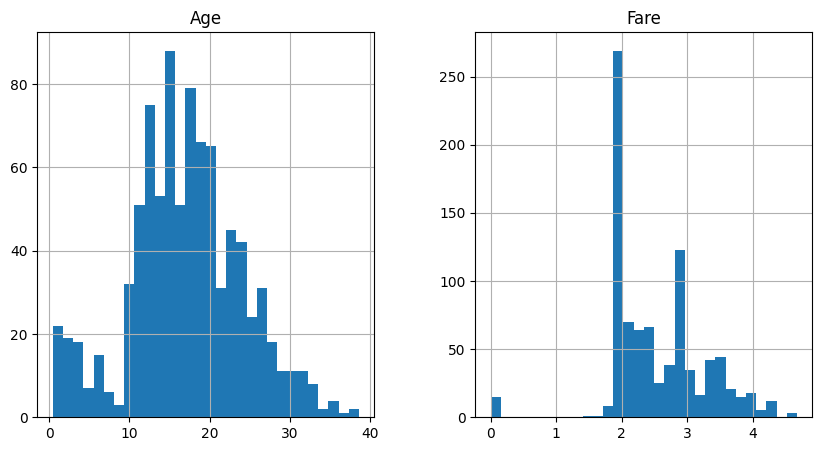

In [18]:
tmp = df.copy()

for var in continuouse_var:
    tmp[var], param = stats.yeojohnson(df[var].fillna(method='bfill'))
tmp[continuouse_var].hist(bins=30, figsize=(10, 5));

In [19]:
fare = df[['Fare'] + [target]].copy()

bins = [0, 7.9104, 14.4542, 31.0, 512.3292]
labels = ['Low', 'Medium', 'High', 'Very High']

fare['Fare'] = pd.cut(fare['Fare'] , bins=bins, labels=labels, include_lowest=True)

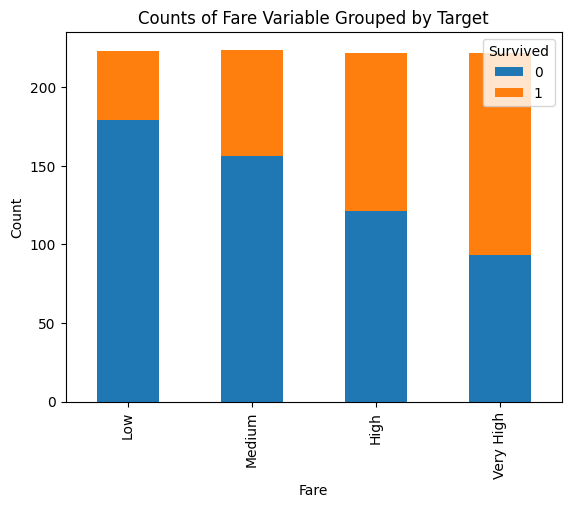

In [20]:
ct = pd.crosstab(fare['Fare'], fare[target])

ct.plot(kind='bar', stacked=True)
plt.xlabel(var)
plt.ylabel('Count')
plt.title(f'Counts of {var} Variable Grouped by Target')
plt.show()

### Categorical Feature

In [21]:
print(len(cat_vars))
df[cat_vars].head()

4


,Sex,Ticket,Cabin,Embarked
0,male,A/5 21171,NaN,S
1,female,PC 17599,C85,C
2,female,STON/O2. 3101282,NaN,S
3,female,113803,C123,S
4,male,373450,NaN,S


### Number of labels: Cardinality

Ticket      0.764310
Cabin       0.164983
Embarked    0.003367
Sex         0.002245
dtype: float64


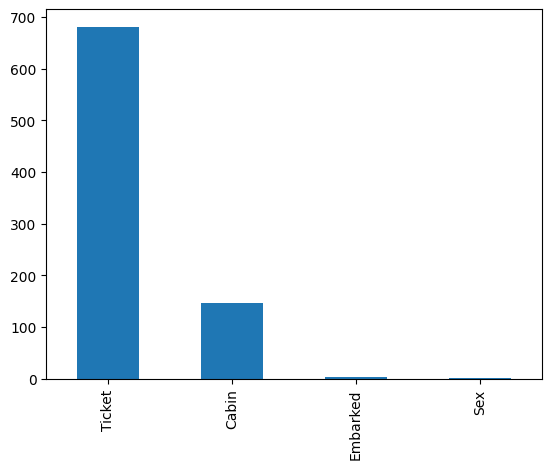

In [22]:
cardinalith = df[cat_vars].nunique().sort_values(ascending=False)
print(cardinalith / df.shape[0])
cardinalith.plot.bar();

In [23]:
df.drop(['Ticket', 'Cabin'], axis=1, inplace=True)
df.shape

(891, 8)

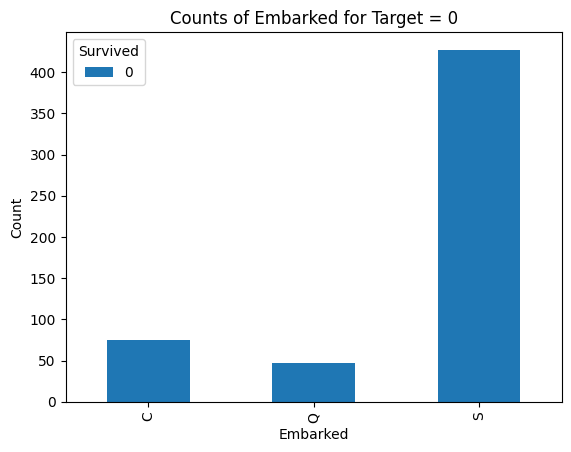

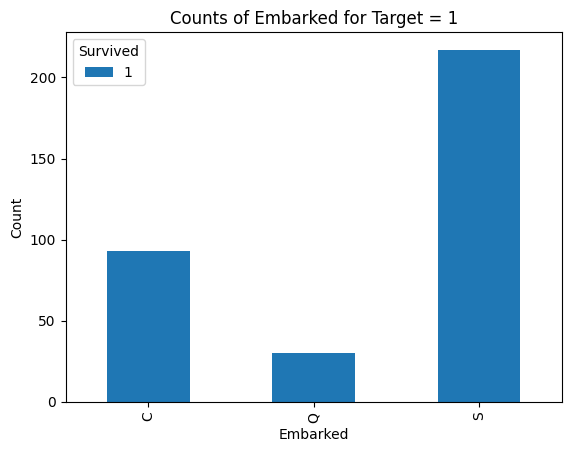

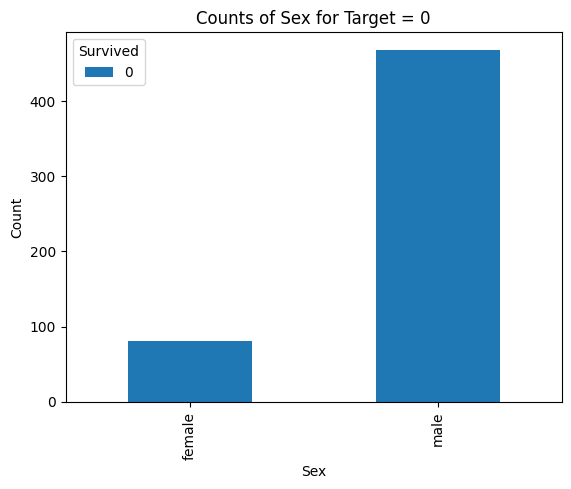

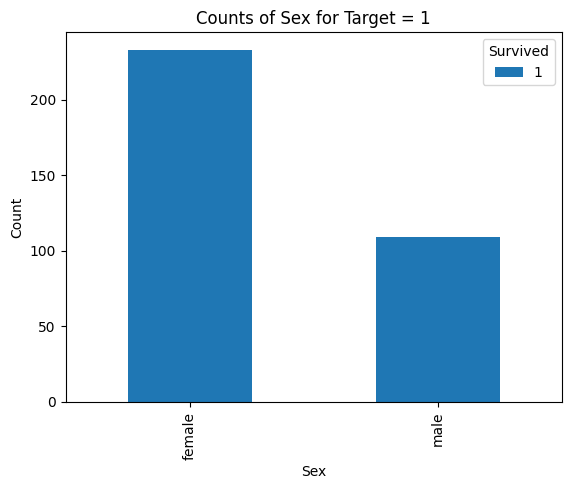

In [24]:
cat_vars = ['Embarked', 'Sex']

for var in cat_vars:
    for target_value in df[target].unique():
        filtered_df = df[df[target] == target_value]
        ct = pd.crosstab(filtered_df[var], filtered_df[target])

        ct.plot(kind='bar', stacked=True)
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.title(f'Counts of {var} for Target = {target_value}')
        plt.show()